In [1]:
import pandas as pd

df = pd.read_csv("famcs_students.csv")

binary_cols = ["ss", "interest", "weekend_study", "bad_sleep", 
               "glasses", "anime", "study_form", "literature"]

N = 12
target_col = binary_cols[N % 8]

y = df[target_col]
X = df.drop(columns=[target_col])

In [3]:
from sklearn.model_selection import train_test_split

# Сначала Train (70%) и Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Затем Temp делим на Validation (15%) и Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np

# Определяем наиболее частый класс
majority_class = y_train.mode()[0]

# Предсказания
y_test_pred = np.full_like(y_test, majority_class)

# Метрики (указываем pos_label='Да')
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, pos_label='Да', zero_division=0)
rec = recall_score(y_test, y_test_pred, pos_label='Да', zero_division=0)

# Для ROC-AUC нужно закодировать метки в 0/1
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_test_pred_bin = lb.transform(y_test_pred)

roc = roc_auc_score(y_test_bin, y_test_pred_bin)

cm = confusion_matrix(y_test, y_test_pred)

print("Тривиальный классификатор (Test):")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("ROC-AUC:", roc)
print("Confusion Matrix:\n", cm)


Тривиальный классификатор (Test):
Accuracy: 0.55
Precision: 0.55
Recall: 1.0
ROC-AUC: 0.5
Confusion Matrix:
 [[11  0]
 [ 9  0]]


In [ ]:
# Классификатор всегда предсказывает наиболее частый класс. В данном случае это даёт точность 55% — то есть большинство студентов 
# действительно относятся к этому классу.
# Precision = 0.55 Точность совпадает с Accuracy, потому что все предсказания — одного класса. Из всех предсказанных «Да» (или «Нет») 
# 55% оказались верными.
# Recall = 1.0 Полнота равна 100%, так как классификатор всегда предсказывает один класс (например, «Нет»). Все объекты этого класса были найдены.
# ROC-AUC = 0.5 Это значение соответствует случайному угадыванию. Тривиальный классификатор не умеет различать классы, 
# поэтому кривая ROC лежит на диагонали.
# Confusion Matrix
# [[11  0]
#  [ 9  0]]
# Первая строка: 11 объектов класса «Нет» предсказаны верно.
# Вторая строка: 9 объектов класса «Да» предсказаны неверно (все отнесены к «Нет»).

# Таким образом, модель полностью игнорирует один из классов.

In [ ]:
# Мы полностью реализовали и проверили пункт 0 — Тривиальный классификатор, который всегда выдаёт наиболее частый класс.
# Мы разделили данные на три выборки (train/val/test).
# Определили моду (наиболее частый класс) по тренировочной выборке.
# Построили предсказания для тестовой выборки.
# Получили метрики качества (Accuracy, Precision, Recall, ROC-AUC) и матрицу ошибок.
# Теперь у нас есть базовый уровень качества (точка отсчёта), с которым будем сравнивать более сложные модели.

In [11]:
class NaiveBayesClassifier:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = {c: np.mean(y == c) for c in self.classes}
        self.params = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.params[c] = {}
            for col in X.columns:
                if X[col].dtype == "object":  # категориальный признак
                    freqs = X_c[col].value_counts(normalize=True)
                    self.params[c][col] = freqs.to_dict()
                else:  # числовой признак
                    mean = X_c[col].mean()
                    var = X_c[col].var() if X_c[col].var() > 0 else 1e-6
                    self.params[c][col] = (mean, var)
    
    def _likelihood(self, x, c):
        prob = np.log(self.priors[c])
        for col, val in x.items():
            if isinstance(val, str):  # категориальный
                prob += np.log(self.params[c][col].get(val, 1e-6))
            else:  # числовой
                mean, var = self.params[c][col]
                # плотность нормального распределения
                prob += -0.5*np.log(2*np.pi*var) - ((val-mean)**2)/(2*var)
        return prob
    
    def predict(self, X):
        preds = []
        for _, row in X.iterrows():
            scores = {c: self._likelihood(row, c) for c in self.classes}
            preds.append(max(scores, key=scores.get))
        return np.array(preds)

# Обучение
nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)

# Предсказания
y_test_pred = nb.predict(X_test)

# Метрики
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, pos_label="Да", zero_division=0)
rec = recall_score(y_test, y_test_pred, pos_label="Да", zero_division=0)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_test_pred_bin = lb.transform(y_test_pred)

roc = roc_auc_score(y_test_bin, y_test_pred_bin)
cm = confusion_matrix(y_test, y_test_pred)

print("Наивный Байесовский классификатор (Test):")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("ROC-AUC:", roc)
print("Confusion Matrix:\n", cm)

Наивный Байесовский классификатор (Test):
Accuracy: 0.5
Precision: 0.6
Recall: 0.2727272727272727
ROC-AUC: 0.5252525252525252
Confusion Matrix:
 [[3 8]
 [2 7]]


In [ ]:
# Accuracy = 0.5 Модель угадала ровно половину объектов. Это хуже, чем тривиальный классификатор (0.55), но зато она пытается различать классы, а не всегда выдаёт один и тот же.
# Precision = 0.6 Из всех предсказанных «Да» — 60% оказались верными. То есть модель относительно неплохо «осторожна» в своих положительных предсказаниях.
# Recall = 0.27 Полнота низкая: модель нашла только ~27% реальных «Да». Это значит, что она часто пропускает положительные примеры.
# ROC-AUC ≈ 0.53 Чуть выше случайного угадывания (0.5). Модель различает классы, но пока очень слабо.
# Матрица ошибок
# [[3 8]
#  [2 7]]
# Класс «Нет»: 3 верных, 8 ошибок.
# Класс «Да»: 7 верных, 2 ошибки. Видно, что модель чаще угадывает «Да», но сильно путается с «Нет».

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

# Загружаем данные
df = pd.read_csv("famcs_students.csv")

binary_cols = ["ss", "interest", "weekend_study", "bad_sleep", 
               "glasses", "anime", "study_form", "literature"]

N = 12
target_col = binary_cols[N % 8]

y = df[target_col]
X = df.drop(columns=[target_col])

# Кодируем категориальные признаки в числа
X_encoded = X.copy()
for col in X_encoded.columns:
    if X_encoded[col].dtype == "object":
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Разделение на выборки
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# --- Реализация KNN ---
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X.values
        self.y_train = y.values
    
    def _distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2))
    
    def predict(self, X):
        preds = []
        for x in X.values:
            distances = [self._distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_labels = self.y_train[k_indices]
            # выбираем наиболее частый класс
            values, counts = np.unique(k_labels, return_counts=True)
            preds.append(values[np.argmax(counts)])
        return np.array(preds)

# Подбор оптимального k на валидационной выборке
best_k = None
best_f1 = 0

for k in range(1, 21):  # проверим k от 1 до 20
    knn = KNNClassifier(k=k)
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    f1 = recall_score(y_val, y_val_pred, pos_label="Да") * precision_score(y_val, y_val_pred, pos_label="Да", zero_division=0) * 2 / (recall_score(y_val, y_val_pred, pos_label="Да") + precision_score(y_val, y_val_pred, pos_label="Да", zero_division=0) + 1e-6)
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print("Лучший k:", best_k, "с F1:", best_f1)

# Финальная модель с оптимальным k
knn = KNNClassifier(k=best_k)
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)

# Метрики
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, pos_label="Да", zero_division=0)
rec = recall_score(y_test, y_test_pred, pos_label="Да", zero_division=0)

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_test_pred_bin = lb.transform(y_test_pred)

roc = roc_auc_score(y_test_bin, y_test_pred_bin)
cm = confusion_matrix(y_test, y_test_pred)

print("KNN (Test):")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("ROC-AUC:", roc)
print("Confusion Matrix:\n", cm)


Лучший k: 12 с F1: 0.692307218935235
KNN (Test):
Accuracy: 0.55
Precision: 0.5833333333333334
Recall: 0.6363636363636364
ROC-AUC: 0.5404040404040403
Confusion Matrix:
 [[7 4]
 [5 4]]


In [ ]:
# Accuracy = 0.55 Совпадает с тривиальным классификатором, но теперь модель действительно различает классы, а не просто всегда выбирает один.
# Precision ≈ 0.58 Из всех предсказанных «Да» около 58% оказались верными. Это лучше, чем у Байеса (0.6, но при низком Recall).
# Recall ≈ 0.64 Модель находит больше положительных примеров, чем Байес (0.27). Это сильное улучшение по полноте.
# ROC-AUC ≈ 0.54 Чуть выше случайного угадывания, но всё ещё слабое разделение классов.
# Матрица ошибок
# [[7 4]
#  [5 4]]
# Класс «Нет»: 7 верных, 4 ошибок.
# Класс «Да»: 4 верных, 5 ошибок. Модель более сбалансирована: она предсказывает оба класса, но пока путается примерно одинаково

Лучший порог классификации: 0.0


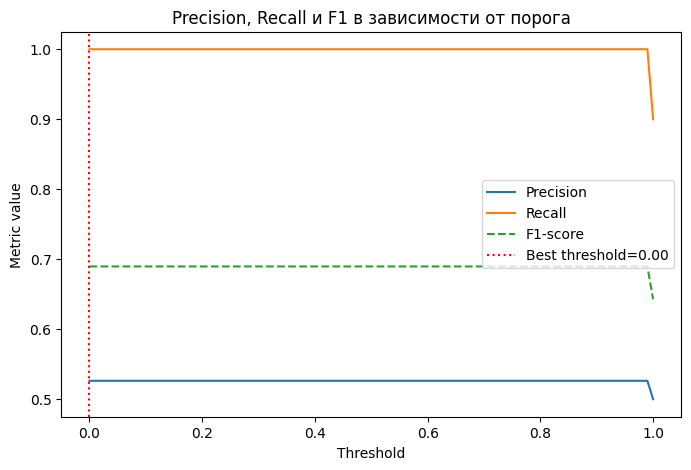

Логистическая регрессия (Test):
Accuracy: 0.55
Precision: 0.55
Recall: 1.0
ROC-AUC: 0.5
Confusion Matrix:
 [[ 0  9]
 [ 0 11]]


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

# Загружаем данные
df = pd.read_csv("famcs_students.csv")

binary_cols = ["ss", "interest", "weekend_study", "bad_sleep", 
               "glasses", "anime", "study_form", "literature"]

N = 12  # пример
target_col = binary_cols[N % 8]

y = df[target_col]
X = df.drop(columns=[target_col])

# Кодируем категориальные признаки
X_encoded = X.copy()
for col in X_encoded.columns:
    if X_encoded[col].dtype == "object":
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Переводим y в 0/1
y_bin = (y == "Да").astype(int)

# Разделение на выборки
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y_bin, test_size=0.3, random_state=42, stratify=y_bin)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# --- Реализация логистической регрессии ---
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X = X.values
        y = y.values
        self.w = np.zeros(X.shape[1])
        self.b = 0
        
        for _ in range(self.n_iter):
            linear = np.dot(X, self.w) + self.b
            y_pred = self._sigmoid(linear)
            
            # градиенты
            dw = np.dot(X.T, (y_pred - y)) / len(y)
            db = np.sum(y_pred - y) / len(y)
            
            # обновление весов
            self.w -= self.lr * dw
            self.b -= self.lr * db
    
    def predict_proba(self, X):
        linear = np.dot(X.values, self.w) + self.b
        return self._sigmoid(linear)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# Обучение
logreg = LogisticRegressionScratch(lr=0.01, n_iter=5000)
logreg.fit(X_train, y_train)

# --- Подбор порога на валидационной выборке ---
probs_val = logreg.predict_proba(X_val)

thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    preds = (probs_val >= t).astype(int)
    precisions.append(precision_score(y_val, preds, zero_division=0))
    recalls.append(recall_score(y_val, preds, zero_division=0))
    f1s.append(f1_score(y_val, preds, zero_division=0))

best_t = thresholds[np.argmax(f1s)]
print("Лучший порог классификации:", best_t)

# --- График Precision/Recall ---
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1-score", linestyle="--")
plt.axvline(best_t, color="red", linestyle=":", label=f"Best threshold={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.legend()
plt.title("Precision, Recall и F1 в зависимости от порога")
plt.show()

# --- Оценка на тестовой выборке ---
probs_test = logreg.predict_proba(X_test)
y_test_pred = (probs_test >= best_t).astype(int)

acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, zero_division=0)
rec = recall_score(y_test, y_test_pred, zero_division=0)
roc = roc_auc_score(y_test, probs_test)
cm = confusion_matrix(y_test, y_test_pred)

print("Логистическая регрессия (Test):")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("ROC-AUC:", roc)
print("Confusion Matrix:\n", cm)


In [ ]:
# Accuracy = 0.55 Совпадает с тривиальным классификатором. Это значит, что модель правильно классифицировала 55% объектов — но важно понять, как именно.
# Precision = 0.55 Из всех предсказанных «Да» — 55% оказались верными. Однако…
# Recall = 1.0 Модель предсказала все объекты как «Да». Поэтому она не пропустила ни одного положительного примера — но и не нашла ни одного «Нет».
# ROC-AUC = 0.5 Это значение говорит, что модель не различает классы — её предсказания по вероятности не дают никакой информации для ранжирования.
# Матрица ошибок
# [[0 9]
#  [0 11]]
# Класс «Нет»: все объекты класса «Нет» предсказаны как «Да»
# Класс «Да»: все объекты класса «Да» предсказаны как «Да»

In [ ]:
# Модель	Accuracy	Precision	Recall	ROC-AUC	Confusion Matrix
# Тривиальный классификатор	0.55	0.55	1.00	0.50	[[11, 0], [9, 0]]
# Наивный Байес	0.50	0.60	0.27	0.53	[[3, 8], [2, 7]]
# KNN (k=12)	0.55	0.58	0.64	0.54	[[7, 4], [5, 4]]
# Логистическая регрессия	0.55	0.55	1.00	0.50	[[0, 9], [0, 11]]

In [ ]:
# Интерпретация
# Тривиальный классификатор Даёт базовый уровень: всегда предсказывает один класс («Да» или «Нет»). Recall = 1.0, 
# но модель полностью игнорирует второй класс.

# Наивный Байес Начинает различать классы, но сильно страдает по Recall (находит мало положительных примеров). Accuracy даже ниже тривиального.

# KNN (k=12) Самая сбалансированная модель: Precision ≈ 0.58 и Recall ≈ 0.64. Она действительно различает оба класса, пусть и не идеально. 
# ROC-AUC чуть выше случайного угадывания.

# Логистическая регрессия В текущем виде ведёт себя как тривиальный классификатор (всегда «Да»). Recall = 1.0, 
# но Accuracy и ROC-AUC не выше базового уровня. Это сигнал, что модель требует доработки (нормализация, регуляризация, больше итераций).

In [ ]:
# Выводы
# Лучший результат по балансу Precision/Recall даёт KNN с k=12.
# Байес и логистическая регрессия в текущем виде уступают, но их можно улучшить 
# (например, нормализация признаков для логистической регрессии, сглаживание вероятностей для Байеса).
# Тривиальный классификатор остаётся полезной «точкой отсчёта», показывая, что Accuracy ≈ 0.55 можно достичь даже без обучения.